In [1]:
import os
import sys
import cv2
import matplotlib.pyplot as plt

import numpy as np
import torch
from torch import nn
from torchvision.transforms.functional import to_tensor, normalize
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device is:", device)

Device is: cuda


In [2]:
from visualize import show_image, draw_predictions

In [3]:
def make_tensor(image, device=None):
    tensor = to_tensor(image).unsqueeze(0)
    tensor = normalize(tensor,
                       mean=(0.485, 0.456, 0.406),
                       std=(0.229, 0.224, 0.225))
    if device:
        tensor = tensor.to(device)
    return tensor

Image shape (640, 640, 3)
Tensor size torch.Size([1, 3, 640, 640])


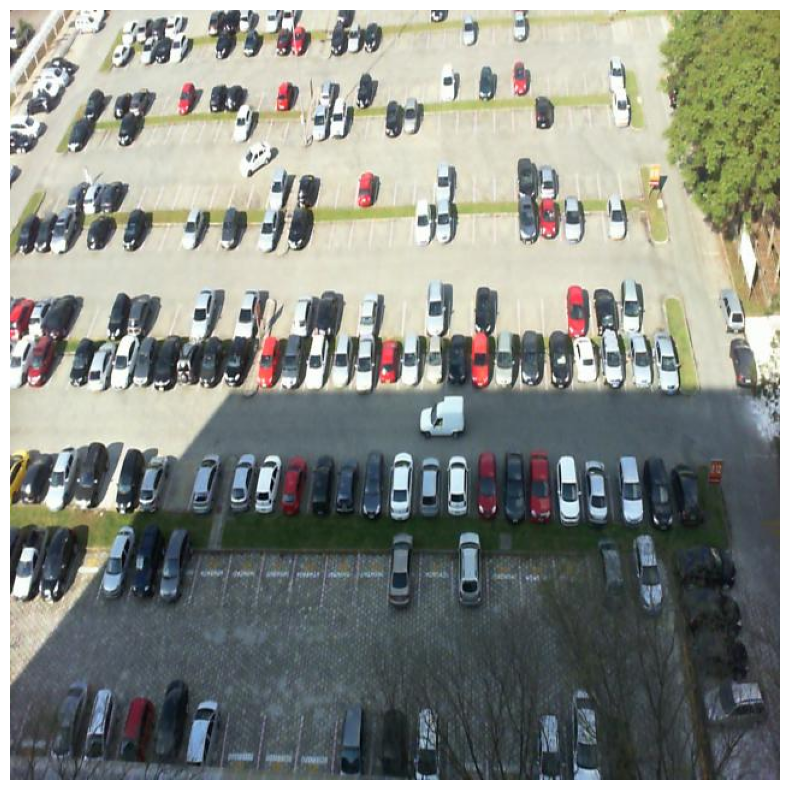

In [4]:
image_example = cv2.imread("data\\train\\2012-09-11_15_16_58_jpg.rf.61d961a86c9a16694403dfcb72cd450c.jpg")
im = Image.open("data\yolo\\train\images\\2012-09-11_15_16_58_jpg.rf.0975fa50f564b303a25de1679a0e5c30.jpg")

image_example = cv2.cvtColor(image_example, cv2.COLOR_BGR2RGB)
print("Image shape", image_example.shape)

tensor_example = make_tensor(image_example, device)
print("Tensor size", tensor_example.size())

show_image(image_example)

## DataLoader

In [5]:
import pandas as pd
from torch.utils.data import DataLoader
from dataset import PKLotDataset
from utils import get_transform, collate_fn, resize_bbox

In [6]:
train_data_dir = "./data/train"
test_data_dir = "./data/test"
val_data_dir = "./data/valid"

In [7]:
train_batch_size = 1
img_train_width = 256
img_train_height = 256

In [8]:
PKLotDataset_train = PKLotDataset(train_data_dir, get_transform(img_train_width, img_train_height), resize_bbox)
PKLotDataset_test = PKLotDataset(test_data_dir, get_transform(img_train_width, img_train_height), resize_bbox)
PKLotDataset_val = PKLotDataset(val_data_dir, get_transform(img_train_width, img_train_height), resize_bbox)

loading annotations into memory...
Done (t=2.72s)
creating index...
index created!
loading annotations into memory...
Done (t=0.55s)
creating index...
index created!
loading annotations into memory...
Done (t=0.49s)
creating index...
index created!


In [9]:
PKLotDataLoader = DataLoader(PKLotDataset_train, batch_size=train_batch_size, shuffle=True, collate_fn=collate_fn)

In [10]:
from torchvision.utils import draw_bounding_boxes

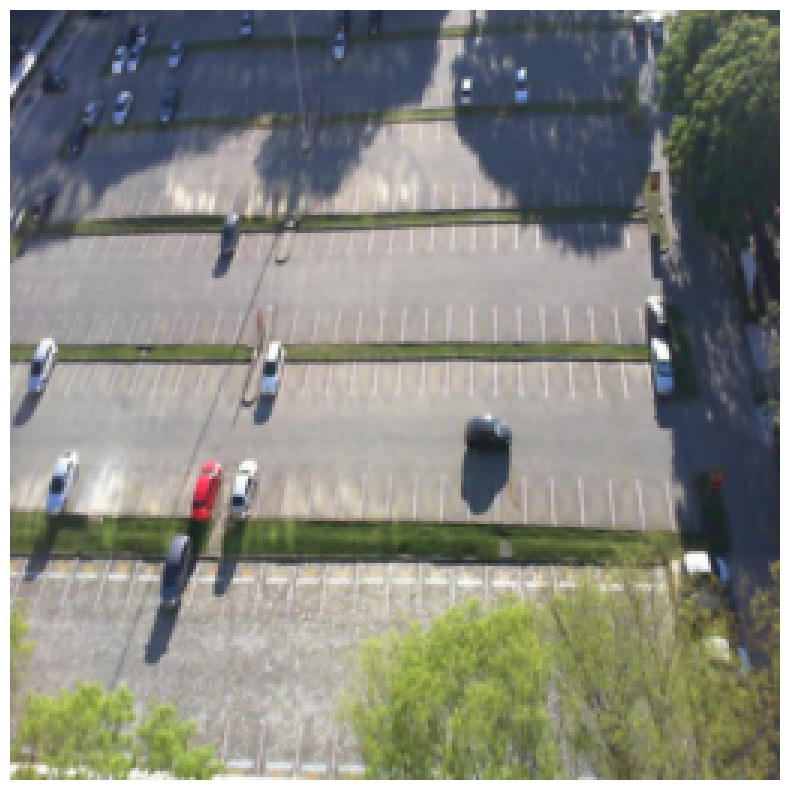

C:\Users\Nastya\AppData\Roaming\Python\Python311\site-packages\torchvision\utils.py:223: UserWarning: Argument 'font_size' will be ignored since 'font' is not set.
  warnings.warn("Argument 'font_size' will be ignored since 'font' is not set.")


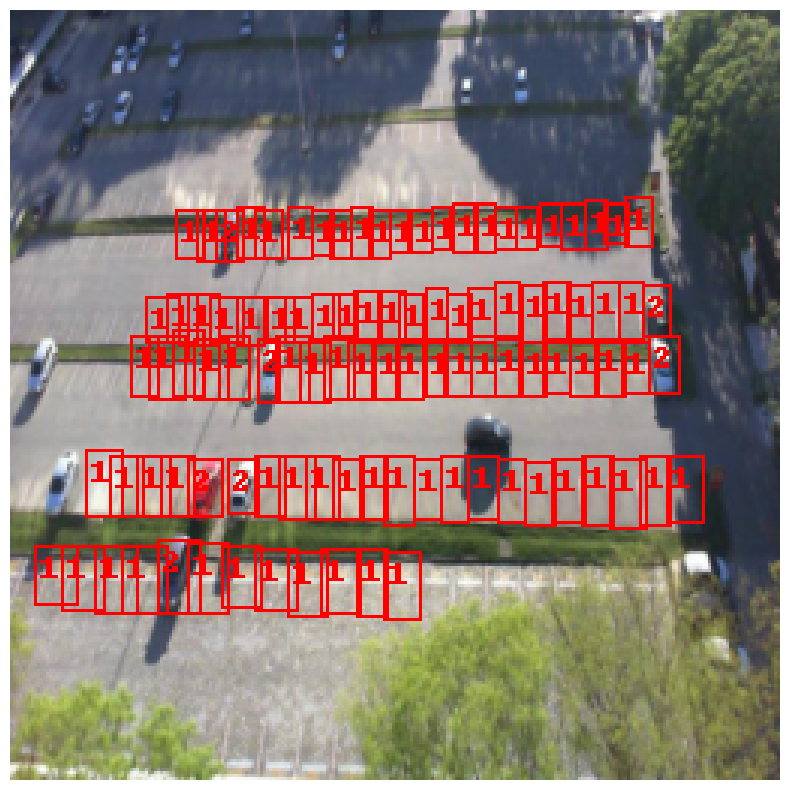

[{'boxes': tensor([[ 55.6000,  66.0000,  64.8000,  82.0000],
        [ 62.0000,  66.0000,  71.0000,  83.0000],
        [ 68.8000,  66.0000,  77.4000,  83.0000],
        [ 75.2000,  65.6000,  84.4000,  82.6000],
        [ 81.6000,  66.4000,  90.2000,  82.4000],
        [ 92.4000,  65.6000, 100.8000,  82.0000],
        [100.0000,  66.4000, 107.0000,  81.6000],
        [106.8000,  66.4000, 113.4000,  82.8000],
        [113.2000,  65.6000, 120.0000,  82.0000],
        [119.6000,  66.4000, 126.8000,  82.0000],
        [126.4000,  66.4000, 132.8000,  80.2000],
        [133.2000,  66.0000, 140.0000,  80.6000],
        [140.4000,  65.6000, 146.8000,  79.2000],
        [147.2000,  64.8000, 154.6000,  80.0000],
        [155.2000,  64.8000, 161.6000,  80.0000],
        [161.2000,  65.2000, 168.2000,  79.0000],
        [168.8000,  65.2000, 175.8000,  79.0000],
        [176.0000,  64.8000, 183.0000,  78.0000],
        [183.2000,  64.8000, 191.0000,  79.0000],
        [191.2000,  63.2000, 198.4000, 

In [11]:
for imgs, annotations in PKLotDataLoader:
    show_image(imgs[0].permute(1, 2, 0))
    

    box = draw_bounding_boxes((imgs[0] * 255).to(torch.uint8), boxes=annotations[0]['boxes'],
                          labels=[str(label.item()) for label in annotations[0]['labels']], # TO DO: CONCAT
                          colors="red",
                          width=1, font_size=1.5)
    show_image(box.detach().permute(1, 2, 0))
    

    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    print(annotations)
    break

## Model

In [12]:
from torchvision.io.image import read_image
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
from model import create_model
from utils import Averager, SaveBestModel, save_loss_plot, save_model
import time
from train import train, validate

In [13]:
frcnn_model = create_model(3)

In [14]:
model = frcnn_model.to(device)
params = [p for p in frcnn_model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

In [15]:
NUM_EPOCHS = 10
OUT_DIR = "./runs/detect/att1"

In [16]:
train_loader = DataLoader(PKLotDataset_train, batch_size=train_batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(PKLotDataset_val, batch_size=train_batch_size, shuffle=True, collate_fn=collate_fn)

In [ ]:
loss_dict = model(images, targets)

In [17]:
# initialize the Averager class
train_loss_hist = Averager()
val_loss_hist = Averager()

train_itr = 1
val_itr = 1

train_loss_list = []
val_loss_list = []

save_best_model = SaveBestModel()
# start the training epochs
for epoch in range(NUM_EPOCHS):
    print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")
    # reset the training and validation loss histories for the current epoch
    train_loss_hist.reset()
    val_loss_hist.reset()
    # start timer and carry out training and validation
    start = time.time()
    train_loss = train(train_loader, model, optimizer, train_loss_hist, train_loss_list)
    train_itr += 1
    val_loss = validate(valid_loader, model, val_loss_hist, val_loss_list)
    val_itr += 1
    print(f"Epoch #{epoch+1} train loss: {train_loss_hist.value:.3f}")   
    print(f"Epoch #{epoch+1} validation loss: {val_loss_hist.value:.3f}")   
    end = time.time()
    print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch}")
    # save the best model till now if we have the least loss in the...
    # ... current epoch
    save_best_model(
        val_loss_hist.value, epoch, model, optimizer
    )
    # save the current epoch model
    save_model(epoch, model, optimizer)
    # save loss plot
    save_loss_plot(OUT_DIR, train_loss, val_loss)
    


EPOCH 1 of 10
Training


  0%|          | 0/8691 [00:00<?, ?it/s]

AssertionError: Expected target boxes to be a tensor of shape [N, 4], got torch.Size([0]).

In [22]:
for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        images, targets = data
        
        images = list(image.to("cuda") for image in images)
        

        targets = [{k: v.to("cuda") for k, v in t.items()} for t in targets]


        loss_dict = model(images, targets)

        print(i)
        print(data)
        print(targets)

0
((tensor([[[0.3569, 0.5490, 0.5765,  ..., 0.3961, 0.3373, 0.3059],
         [0.3373, 0.4980, 0.5529,  ..., 0.3804, 0.3569, 0.3216],
         [0.3451, 0.4863, 0.5412,  ..., 0.3686, 0.3529, 0.3176],
         ...,
         [0.7686, 0.6275, 0.5765,  ..., 0.1490, 0.1451, 0.1451],
         [0.7333, 0.6039, 0.5765,  ..., 0.1608, 0.1490, 0.1490],
         [0.7176, 0.6078, 0.5725,  ..., 0.1686, 0.1529, 0.1529]],

        [[0.3373, 0.5608, 0.6039,  ..., 0.4078, 0.3451, 0.3137],
         [0.3294, 0.5137, 0.5765,  ..., 0.3922, 0.3647, 0.3294],
         [0.3490, 0.5098, 0.5686,  ..., 0.3804, 0.3608, 0.3255],
         ...,
         [0.7294, 0.5804, 0.5137,  ..., 0.1020, 0.0941, 0.0902],
         [0.7098, 0.5725, 0.5294,  ..., 0.1098, 0.0902, 0.0902],
         [0.7059, 0.5843, 0.5333,  ..., 0.1176, 0.0941, 0.0902]],

        [[0.2627, 0.3373, 0.3490,  ..., 0.3020, 0.2510, 0.2196],
         [0.2275, 0.2902, 0.3333,  ..., 0.2824, 0.2667, 0.2392],
         [0.2196, 0.2902, 0.3451,  ..., 0.2667, 0.2627

AssertionError: Expected target boxes to be a tensor of shape [N, 4], got torch.Size([0]).

In [23]:
model.predict

AttributeError: 'FasterRCNN' object has no attribute 'predict'

In [24]:
img = read_image("data\yolo\\train\images\\2012-09-11_15_16_58_jpg.rf.0975fa50f564b303a25de1679a0e5c30.jpg")

In [31]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.transforms.functional import to_pil_image

In [32]:
weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn_v2(weights=weights, quantize=True)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [33]:
preprocess = weights.transforms()
batch = [preprocess(img)]

In [36]:
%%timeit

prediction = model(batch)[0]
# labels = [weights.meta["categories"][i] for i in prediction["labels"]]
# box = draw_bounding_boxes(img, boxes=prediction["boxes"],
#                           labels=labels, # TO DO: CONCAT
#                           colors="red",
#                           width=4, font_size=30)
# im = to_pil_image(box.detach())
# show_image(box.detach().permute(1, 2, 0))

3.13 s ± 74.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
prediction

{'boxes': tensor([[1194.9323,  308.0561, 1243.8206,  354.7970],
         [ 248.5931,  483.9168,  304.4642,  554.3513],
         [ 365.5113,  414.4409,  409.3587,  468.8619],
         [1177.1245,  259.3088, 1223.0668,  302.7690],
         [ 405.8813,  415.8095,  451.5688,  471.0982],
         [ 381.3175,  121.6883,  443.2252,  156.9484],
         [ 745.1266,  487.6313,  782.8477,  557.7158],
         [ 991.5645,  172.5128, 1027.5004,  216.1998],
         [ 296.3864,  416.8824,  350.9815,  471.4773],
         [ 201.4834,  479.2813,  259.0199,  550.0193]],
        grad_fn=<StackBackward0>),
 'labels': tensor([ 3,  3,  3,  3,  3,  3, 77,  3,  3,  3]),
 'scores': tensor([0.9775, 0.9743, 0.9494, 0.9488, 0.9386, 0.9338, 0.9279, 0.9231, 0.9218,
         0.9089], grad_fn=<IndexBackward0>)}